# Notebook Initialization

In [26]:
# %load nb_init.py

from pathlib import Path
import pandas as pd

base_dir = Path.cwd().parent
config_dir = base_dir / "config"
data_dir = base_dir / "data"
docs_dir = base_dir / "docs"
figures_dir = docs_dir / "figures"
models_dir = base_dir / "models"
logs_dir = base_dir / "logs"
images_input_dir = data_dir / "COVID19"
preprocessed_dir = data_dir / "preprocessed"
output_dir = data_dir / "output"

# Directories used to train the CNN (image by image) 
cnn_data_dir = data_dir / "modelling" / "cnn"
cnn_train_dir = cnn_data_dir / "train"
cnn_test_dir = cnn_data_dir / "test"

metadata_file = images_input_dir / "metadata.csv"
labels_file = images_input_dir / "unzip_filenames.csv"
preprocessed_labels_file = preprocessed_dir / "labels.parquet"

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

config_file = config_dir / "tfg.conf"

from pyhocon import ConfigFactory
config = None

def load_config():
    return ConfigFactory.parse_file(config_file)

config = load_config()
    
import sys

if str(base_dir / "src") not in sys.path:
    sys.path.append(str(base_dir / "src"))

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
config.as_plain_ordered_dict()

OrderedDict([('tfg',
              OrderedDict([('seed', 42),
                           ('eda',
                            OrderedDict([('csv_options',
                                          OrderedDict([('header', 'true'),
                                                       ('sep', ','),
                                                       ('inferSchema',
                                                        'true')]))])),
                           ('training',
                            OrderedDict([('test_fraction', 0.1),
                                         ('val_fraction', 0.1),
                                         ('images_per_clip', 70),
                                         ('batch_size', 32)]))])),
             ('data',
              OrderedDict([('train_df',
                            OrderedDict([('path',
                                          'preprocessed/training_df.csv')])),
                           ('val_df',
                            Or

In [3]:
spark

In [4]:
from tfg import DataRepository

repo = DataRepository(config=config, base_data_path=data_dir)

# Load labels

In [5]:
labels = spark.read.parquet(str(preprocessed_labels_file))

labels.show(5)

+----------+-------+-------+-----+---------+
|patient_id|scan_id|n_slice|label|num_clips|
+----------+-------+-------+-----+---------+
|         0|   3131|    285|   CP|        5|
|         0|   3132|     42|   CP|        1|
|         0|   3133|    290|   CP|        5|
|         0|   3134|     37|   CP|        1|
|         0|   3135|    269|   CP|        4|
+----------+-------+-------+-----+---------+
only showing top 5 rows



In [6]:
num_labels = labels.count()
num_labels

4178

In [7]:
labels\
    .groupBy("label")\
    .agg(
        F.count("*").alias("count"),
        F.round((F.count("*") / num_labels), 4).alias("pct"),
    )\
    .show()

+------+-----+------+
| label|count|   pct|
+------+-----+------+
|    CP| 1556|0.3724|
|   NCP| 1544|0.3696|
|Normal| 1078| 0.258|
+------+-----+------+



In [8]:
labels.select("patient_id").distinct().count()

2742

# Split patient ids into train / test

In [9]:
seed = config.get_int("tfg.seed")
test_fraction = config.get_float("tfg.training.test_fraction")
val_fraction = config.get_float("tfg.training.val_fraction")
train_fraction = 1 - test_fraction - val_fraction
split_weights = [train_fraction, val_fraction, test_fraction]
split_weights

[0.8, 0.1, 0.1]

In [10]:
patient_ids = labels.select("patient_id").distinct()

id_dfs = patient_ids.randomSplit(split_weights, seed=seed)
train_ids = id_dfs[0]
val_ids =  id_dfs[1]
test_ids =  id_dfs[2]

train_labels = labels.join(train_ids, ["patient_id"], "inner")
val_labels = labels.join(val_ids, ["patient_id"], "inner")
test_labels = labels.join(test_ids, ["patient_id"], "inner")

train_count = train_labels.count()
val_count = val_labels.count()
test_count = test_labels.count()

print(f"Training rows: {train_count}")
print(f"Validation rows: {val_count}")
print(f"Test rows: {test_count}")

train_labels.show(5)
val_labels.show(5)
test_labels.show(5)

Training rows: 3350
Validation rows: 402
Test rows: 426
+----------+-------+-------+-----+---------+
|patient_id|scan_id|n_slice|label|num_clips|
+----------+-------+-------+-----+---------+
|         0|   3131|    285|   CP|        5|
|         0|   3132|     42|   CP|        1|
|         0|   3133|    290|   CP|        5|
|         0|   3134|     37|   CP|        1|
|         0|   3135|    269|   CP|        4|
+----------+-------+-------+-----+---------+
only showing top 5 rows

+----------+-------+-------+-----+---------+
|patient_id|scan_id|n_slice|label|num_clips|
+----------+-------+-------+-----+---------+
|      1075|   3118|    553|   CP|        8|
|      1075|   3119|     70|   CP|        1|
|      1080|   3125|     64|   CP|        1|
|      1093|   3311|    173|   CP|        3|
|      1394|   3847|     62|   CP|        1|
+----------+-------+-------+-----+---------+
only showing top 5 rows

+----------+-------+-------+-----+---------+
|patient_id|scan_id|n_slice|label|num_c

In [11]:
print("Train label counts and percentages")
train_labels\
    .groupBy("label")\
    .agg(
        F.count("*").alias("count"),
        F.round((F.count("*") / train_count), 2).alias("pct"),
    )\
    .show()

print("Validation label counts and percentages")
val_labels\
    .groupBy("label")\
    .agg(
        F.count("*").alias("count"),
        F.round((F.count("*") / val_count), 2).alias("pct"),
    )\
    .show()

print("Test label counts and labels")
test_labels\
    .groupBy("label")\
    .agg(
        F.count("*").alias("count"),
        F.round((F.count("*") / test_count), 2).alias("pct"),
    )\
    .show()

Train label counts and percentages
+------+-----+----+
| label|count| pct|
+------+-----+----+
|    CP| 1229|0.37|
|   NCP| 1229|0.37|
|Normal|  892|0.27|
+------+-----+----+

Validation label counts and percentages
+------+-----+----+
| label|count| pct|
+------+-----+----+
|    CP|  152|0.38|
|   NCP|  158|0.39|
|Normal|   92|0.23|
+------+-----+----+

Test label counts and labels
+------+-----+----+
| label|count| pct|
+------+-----+----+
|    CP|  175|0.41|
|   NCP|  157|0.37|
|Normal|   94|0.22|
+------+-----+----+



# Create datasets for the CNN

For each of the train/validation/test sets we have, we will create a pandas dataframe, and we'll use these dataframe to create the data generators for our model.

In [12]:
from dataclasses import dataclass

from pyspark.sql import Row


@dataclass
class Observation:
    patient_id: int
    scan_id: int
    n_slice: int
    num_clips: int
    label: str

    @staticmethod
    def from_row(r: Row) -> "Observation":
        return Observation(
            patient_id=r.patient_id,
            scan_id=r.scan_id,
            n_slice=r.n_slice,
            num_clips=r.num_clips,
            label=r.label,
        )

In [20]:
from tqdm.notebook import tqdm
import pandas as pd
from pathlib import Path

def create_df(config, labels):
    raw_images = {
        "label": [],
        "file": [],
        "patient_id": [],
        "scan_id": [],
        "n_slice": [],
        "num_clips": [],
        "seq_num": [],
        "clip_num": [],
    }

    IMAGES_PER_CLIP = config.get_int("tfg.training.images_per_clip")

    for r in labels.collect():
        obs = Observation.from_row(r)
        scan_path = Path(f"{obs.label}/{obs.patient_id}/{obs.scan_id}")
        absolute_scan_path = images_input_dir / scan_path
        # different directories have different formats
        img_ext = next(absolute_scan_path.glob("*.*")).suffix

        scan_images = []
        seq_nums = []
        clip_nums = []

        seq_num = 0
        images_input_dir_str = str(images_input_dir)
        path_offset = len(images_input_dir_str) + 1
        for seq_num, img in enumerate(absolute_scan_path.glob(f"*{img_ext}")):
            img_to_append = str(img)[path_offset:]
            scan_images.append(img_to_append)
            seq_nums.append(seq_num)
            clip_nums.append(seq_num // IMAGES_PER_CLIP)
            seq_num = seq_num + 1

        raw_images["label"].extend([obs.label] * obs.n_slice)
        raw_images["file"].extend(scan_images)
        raw_images["patient_id"].extend([obs.patient_id] * obs.n_slice)
        raw_images["scan_id"].extend([obs.scan_id] * obs.n_slice)
        raw_images["n_slice"].extend([obs.n_slice] * obs.n_slice)
        raw_images["num_clips"].extend([obs.patient_id] * obs.n_slice)
        raw_images["seq_num"].extend(seq_nums)
        raw_images["clip_num"].extend(clip_nums)
        
    return pd.DataFrame(raw_images)

In [21]:
train_df = create_df(config, train_labels)
print(f"{train_df.shape}")
train_df

(331286, 8)


,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/0/3131/0275.png,0,3131,285,0,0,0
1,CP,CP/0/3131/0064.png,0,3131,285,0,1,0
2,CP,CP/0/3131/0083.png,0,3131,285,0,2,0
3,CP,CP/0/3131/0160.png,0,3131,285,0,3,0
4,CP,CP/0/3131/0127.png,0,3131,285,0,4,0
...,...,...,...,...,...,...,...,...
331281,Normal,Normal/1924/379/0014.png,1924,379,98,1924,93,1
331282,Normal,Normal/1924/379/0001.png,1924,379,98,1924,94,1
331283,Normal,Normal/1924/379/0027.png,1924,379,98,1924,95,1
331284,Normal,Normal/1924/379/0031.png,1924,379,98,1924,96,1


In [26]:
repo.save("train_df", train_df)

True

In [27]:
val_df = create_df(config, val_labels)
print(f"{val_df.shape}")
val_df

(39828, 8)


,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/1075/3118/0543.jpg,1075,3118,553,1075,0,0
1,CP,CP/1075/3118/0174.jpg,1075,3118,553,1075,1,0
2,CP,CP/1075/3118/0130.jpg,1075,3118,553,1075,2,0
3,CP,CP/1075/3118/0525.jpg,1075,3118,553,1075,3,0
4,CP,CP/1075/3118/0152.jpg,1075,3118,553,1075,4,0
...,...,...,...,...,...,...,...,...
39823,Normal,Normal/1920/375/0014.png,1920,375,100,1920,95,1
39824,Normal,Normal/1920/375/0001.png,1920,375,100,1920,96,1
39825,Normal,Normal/1920/375/0027.png,1920,375,100,1920,97,1
39826,Normal,Normal/1920/375/0031.png,1920,375,100,1920,98,1


In [28]:
repo.save("val_df", val_df)

True

In [29]:
test_df = create_df(config, test_labels)
print(f"{test_df.shape}")
test_df

(40415, 8)


,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/1/3143/0275.png,1,3143,300,1,0,0
1,CP,CP/1/3143/0064.png,1,3143,300,1,1,0
2,CP,CP/1/3143/0083.png,1,3143,300,1,2,0
3,CP,CP/1/3143/0160.png,1,3143,300,1,3,0
4,CP,CP/1/3143/0286.png,1,3143,300,1,4,0
...,...,...,...,...,...,...,...,...
40410,Normal,Normal/1917/372/0014.png,1917,372,96,1917,91,1
40411,Normal,Normal/1917/372/0001.png,1917,372,96,1917,92,1
40412,Normal,Normal/1917/372/0027.png,1917,372,96,1917,93,1
40413,Normal,Normal/1917/372/0031.png,1917,372,96,1917,94,1


In [30]:
repo.save("test_df", test_df)

True

# Data Generators

In [5]:
train_df = repo.load("train_df")
train_df.head(5)

,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/0/3131/0275.png,0,3131,285,0,0,0
1,CP,CP/0/3131/0064.png,0,3131,285,0,1,0
2,CP,CP/0/3131/0083.png,0,3131,285,0,2,0
3,CP,CP/0/3131/0160.png,0,3131,285,0,3,0
4,CP,CP/0/3131/0127.png,0,3131,285,0,4,0


In [6]:
val_df = repo.load("val_df")
val_df.head(5)

,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/1075/3118/0543.jpg,1075,3118,553,1075,0,0
1,CP,CP/1075/3118/0174.jpg,1075,3118,553,1075,1,0
2,CP,CP/1075/3118/0130.jpg,1075,3118,553,1075,2,0
3,CP,CP/1075/3118/0525.jpg,1075,3118,553,1075,3,0
4,CP,CP/1075/3118/0152.jpg,1075,3118,553,1075,4,0


In [34]:
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img

img_sizes = set()

for r in tqdm(train_df.drop_duplicates(["patient_id", "scan_id"]).iterrows()):
    img_path = images_input_dir / r[1]["file"]
    img_sizes.add(load_img(img_path).size)

img_sizes

{(512, 512), (768, 768), (1024, 1024), (1168, 1168)}

In [35]:
val_img_sizes = set()

for r in tqdm(val_df.drop_duplicates(["patient_id", "scan_id"]).iterrows()):
    img_path = images_input_dir / r[1]["file"]
    val_img_sizes.add(load_img(img_path).size)

val_img_sizes

{(512, 512)}

In [7]:
from keras_preprocessing.image import ImageDataGenerator

seed = config.get_int("tfg.seed")
val_fraction = config.get_float("tfg.training.val_fraction")
train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)
batch_size = config.get_int("tfg.training.batch_size")

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    subset="training",
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode="categorical",
    target_size=(512, 512))

valid_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode="categorical",
    target_size=(512, 512))

Found 331286 validated image filenames belonging to 3 classes.
Found 39828 validated image filenames belonging to 3 classes.


# Create model

In [8]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers as reg
from tensorflow.keras import callbacks

In [10]:
input_images = keras.Input(shape=(512, 512, 3), name="input_images")

In [11]:
filters = 16
initial_dense_features = 256
num_features = 64
num_classes = 3
num_layers = 0
cnn_net = input_images

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}", kernel_regularizer=reg.l2(l=0.01))(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

# cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}", kernel_regularizer=reg.l2(l=0.01))(cnn_net)
# cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
# num_layers = num_layers + 1

cnn_net = layers.Flatten(name=f"flatten")(cnn_net)

# cnn_net = layers.Dense(initial_dense_features, activation="relu", name="dense_01")(cnn_net)
# cnn_net = layers.Dropout(0.2, name="dropout_01")(cnn_net)

cnn_net = layers.Dense(initial_dense_features // 2, activation="relu", name="dense_02")(cnn_net)
cnn_net = layers.Dropout(0.2, name="dropout_02")(cnn_net)


cnn_net = layers.Dense(num_features, activation="relu", name="dense_03")(cnn_net)
cnn_net = layers.Dropout(0.2, name="dropout_03")(cnn_net)

output_layer = layers.Dense(num_classes, activation="softmax", name="output")
outputs = output_layer(cnn_net)

model = keras.Model(inputs=input_images, outputs=outputs, name="covid_classifier")

In [12]:
model.summary()

Model: "covid_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d_01 (Conv2D)           (None, 512, 512, 16)      448       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 256, 256, 32)      4640      
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 64, 64, 64)   

In [13]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['categorical_accuracy'])

In [48]:
train_generator.n // train_generator.batch_size

10352

In [14]:
cnn_model_dir = models_dir / "cnn"
cnn_model_dir.mkdir(exist_ok=True)
cnn_checkpoint_dir = cnn_model_dir / "checkpoint"
cnn_checkpoint_dir.mkdir(exist_ok=True)

cnn_logs_dir = logs_dir / "cnn"
cnn_logs_dir.mkdir(exist_ok=True)

In [15]:
checkpointer = callbacks.ModelCheckpoint(
    str(cnn_checkpoint_dir),
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch"
)

tensorboard_logger = callbacks.TensorBoard(
    log_dir=str(cnn_logs_dir),
    histogram_freq=1,
    write_graph=False,
    write_images=False,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None
)

#model_callbacks = [checkpointer, tensorboard_logger]
model_callbacks = [checkpointer]

In [16]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

fit_history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5,
                    callbacks=model_callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
10352/10352 [==============================] - ETA: 0s - loss: 0.2420 - categorical_accuracy: 0.9154
Epoch 00001: val_loss improved from inf to 0.23183, saving model to /home/albert/projects/tfg/models/cnn/checkpoint
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/albert/projects/tfg/models/cnn/checkpoint/assets
10352/10352 [==============================] - 8714s 842ms/step - loss: 0.2420 - categorical_accuracy: 0.9154 - val_loss: 0.2318 - val_categorical_accuracy: 0.9214
Epoch 2/5
10352/10352 [==============================] - ETA: 0s - loss: 0.1070 - categorical_accuracy: 0.9675
Epoch 00002: val_loss improved from 0.23183 to 0.22849, saving model to /home/albert/projects/tfg/models/cnn/checkpoint
INFO:tensorflow:Assets written to: /home/albert/projects/tfg/models/cnn/checkpoint/assets
10352/10352 [============================

In [19]:
fit_history.history

{'loss': [0.24197416007518768,
  0.10702913254499435,
  0.0856880471110344,
  0.07496210932731628,
  0.06696616858243942],
 'categorical_accuracy': [0.9153786897659302,
  0.9674932360649109,
  0.9757497310638428,
  0.9797013998031616,
  0.9825239777565002],
 'val_loss': [0.23182688653469086,
  0.22849319875240326,
  0.3110477328300476,
  0.2613295912742615,
  0.42864999175071716],
 'val_categorical_accuracy': [0.9214228391647339,
  0.9303908944129944,
  0.9423231482505798,
  0.944784939289093,
  0.9254923462867737]}

In [22]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(13, 9)})

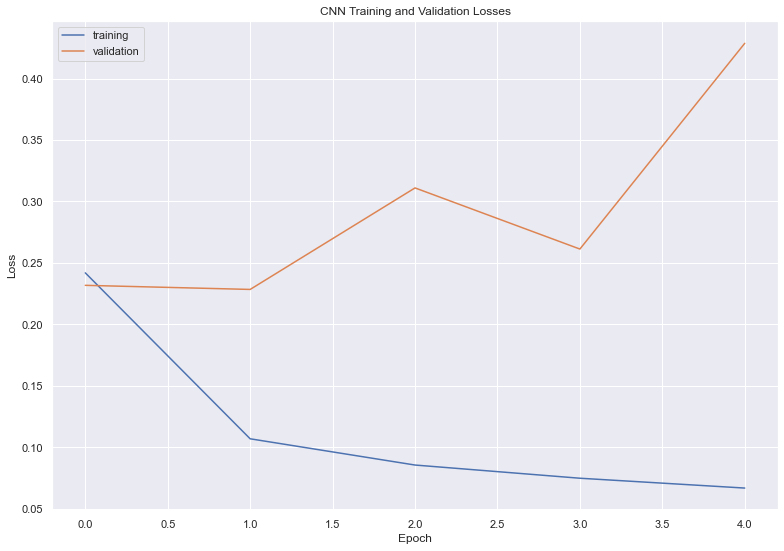

In [27]:
import matplotlib.pyplot as plt

plt.plot(fit_history.history["loss"], label="training")
plt.plot(fit_history.history["val_loss"], label="validation")
plt.title("CNN Training and Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(figures_dir / "cnn_loss.png")
plt.show()

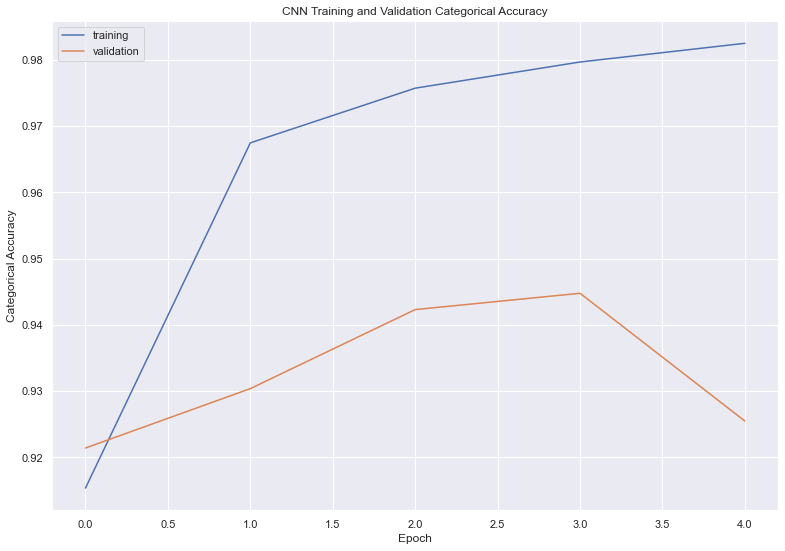

In [28]:
import matplotlib.pyplot as plt

plt.plot(fit_history.history["categorical_accuracy"], label="training")
plt.plot(fit_history.history["val_categorical_accuracy"], label="validation")
plt.title("CNN Training and Validation Categorical Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")
plt.legend()
plt.savefig(figures_dir / "cnn_cat_accuracy.png")
plt.show()